Some exploratory data analysis of the two sigma training dataset, focusing on portfolio or market returns

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

with pd.HDFStore('../data/train.h5') as train:
    df = train.get('train')

In [4]:
print('Shape : {}'.format(df.shape))

Shape : (1710756, 111)


In [5]:
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


In [6]:
len(df.id.unique()) # how many assets (instruments) are we tracking?

1424

In [7]:
len(df.timestamp.unique()) # how many periods?

1813

Looks like we have 1,424 assets that we are tracking across 1,813 time periods. We can't make any assumptions about the time period length - it could be days, hours, minutes, etc. as long as the period is uniform.

The set of assets could be considered as the market portfolio. It would be interesting to see if these assets could be grouped into classes based on the observed data and features. For example, asset classes may be equities, bonds, etc. 

One approach may be to determine market return for a specific time period, and based on that predict the expected return of each asset based on autocorrelation and on how the asset returns correlate to market returns, given an asset class and other features.

For now let's try to visualize the market return over the time period.

In [8]:
market_df = df[['timestamp', 'y']].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
market_df.head()

timestamp         y                 
                 mean       std    len
0         0 -0.001870  0.026646  750.0
1         1  0.000501  0.028422  750.0
2         2 -0.005787  0.029281  750.0
3         3  0.001633  0.025333  750.0
4         4 -0.004309  0.035929  750.0

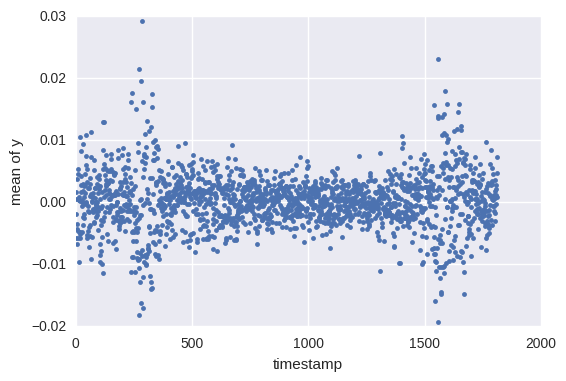

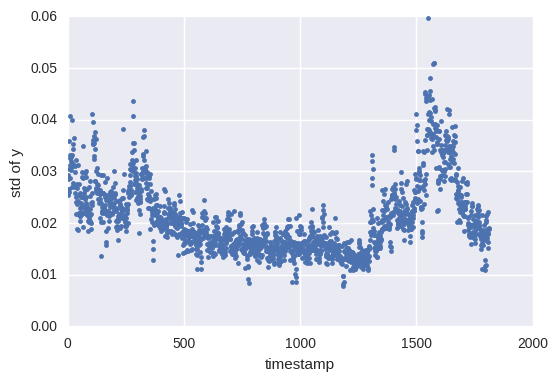

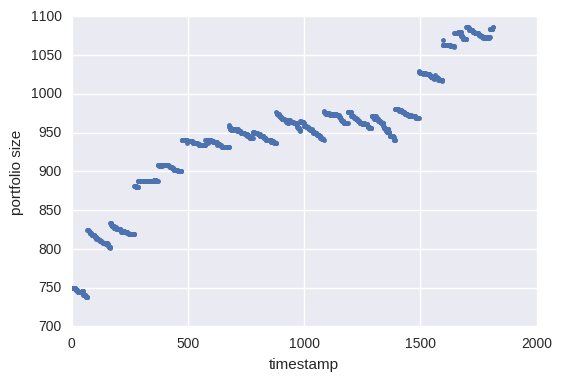

In [9]:
t      = market_df['timestamp']
y_mean = np.array(market_df['y']['mean'])
y_std  = np.array(market_df['y']['std'])
n      = np.array(market_df['y']['len'])

plt.figure()
plt.plot(t, y_mean, '.')
plt.xlabel('timestamp')
plt.ylabel('mean of y')

plt.figure()
plt.plot(t, y_std, '.')
plt.xlabel('timestamp')
plt.ylabel('std of y')

plt.figure()
plt.plot(t, n, '.')
plt.xlabel('timestamp')
plt.ylabel('portfolio size')

Looks like two periods of high variance that are correlated with rapid increases in the number of assets. The number of assets being tracked increases from 750 in the first timestamp to just under 1100 in the last. 

The total number of assets across all timestamps is 1424, so some assets are being dropped as well. It looks like assets are added to the portfolio periodically (see the gaps in the chart), and sold off more slowly.

Let's derive a price chart for these returns. We can take the log of the periodic mean returns and get a cumulative sum for each time period to derive a fairly good approximation of a price chart for the portfolio.

In [10]:
simple_ret = y_mean # this is a vector of the mean of asset returns for each timestamp
cum_ret = np.log(1+simple_ret).cumsum()

In [11]:
portfolio_mean = np.mean(cum_ret)
portfolio_std = np.std(cum_ret)
print("portfolio mean periodic return: " + str(portfolio_mean))
print("portfolio std dev of periodic returns: " + str(portfolio_std))

portfolio mean periodic return: 0.183126
portfolio std dev of periodic returns: 0.0922067


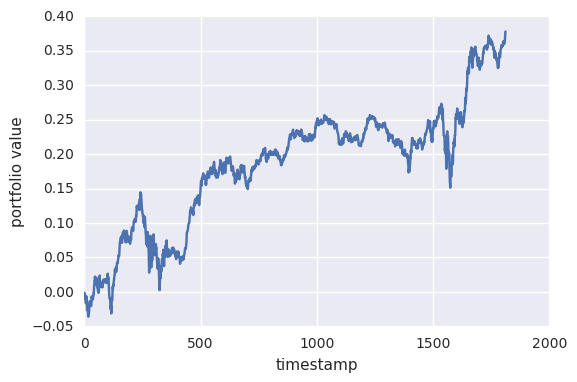

In [10]:
plt.figure()
plt.plot(t, cum_ret)
plt.xlabel('timestamp')
plt.ylabel('portfolio value')

Taking the log returns and adding them up is a good approximation for the compounding of returns.

It would be interesting to see how the returns of individual assets correlate to the portfolio returns (determine alpha and beta for each asset with respect to the portfolio). Maybe we can use the portfolio return as a proxy for the market return. 

Recall that the simple regression model for the return of an individual asset, using the market (or index) return as a feature is:

return[asset i] = alpha[asset i] + beta * return[market]

Alpha represents the component of asset returns that cannot be attributed to the market portfolio returns (and may reflect the skill - or luck - of the portfolio manager). Beta represents the asset volatility with respect to the market portfolio. For example, an asset with a beta of 1.5 will rise or fall on average 1.5 times the value of the market portfolio (or index).

Let's take a look at some individual assets:

In [12]:
assets_df = df.groupby('id')['y'].agg(['mean','std',len]).reset_index()
assets_df.head()

,id,mean,std,len
0,0,0.000207,0.014373,1646.0
1,6,0.000154,0.014151,728.0
2,7,0.000524,0.021986,1543.0
3,10,-0.000721,0.027715,116.0
4,11,0.000158,0.012680,1813.0


In [13]:
assets_df = assets_df.sort_values(by='mean')
assets_df.head()

,id,mean,std,len
954,1431,-0.035077,0.063072,27.0
62,93,-0.032797,0.069079,25.0
585,882,-0.015408,0.029595,14.0
1085,1637,-0.014028,0.057750,245.0
742,1118,-0.011848,0.056539,133.0


In [14]:
assets_df.tail()

,id,mean,std,len
506,767,0.006385,0.022595,14.0
148,226,0.006400,0.024154,19.0
545,824,0.006730,0.045240,77.0
1195,1809,0.007290,0.017904,14.0
726,1089,0.010827,0.024236,14.0


In [15]:
assets_df.describe()

,id,mean,std,len
count,1424.000000,1424.000000,1424.000000,1424.000000
mean,1074.492978,0.000186,0.022430,1201.373535
std,621.613221,0.001884,0.008493,646.399902
min,0.000000,-0.035077,0.003536,2.000000
25%,544.500000,-0.000075,0.016401,571.250000
50%,1066.500000,0.000275,0.020841,1485.000000
75%,1610.250000,0.000657,0.026920,1813.000000
max,2158.000000,0.010827,0.069079,1813.000000


Looks like individual asset returns range from a min of -0.035077 to a high of 0.010827, with a mean return of 0.000186 and a std dev of 0.001884.

Assets have a mean holding period of roughly 1201 periods with a std dev of 646 periods, with a min holding period of 2 and a max of 1813 (all periods).

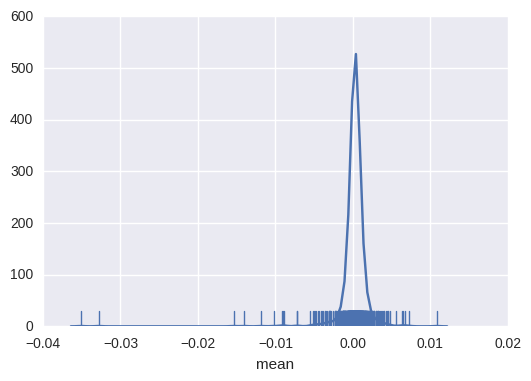

In [16]:
sns.distplot(assets_df['mean'], rug=True, hist=False)

Checking for correlations between asset return, std and holding period.

In [17]:
assets_df.corr()

,id,mean,std,len
id,1.000000,0.015706,0.023342,0.057940
mean,0.015706,1.000000,-0.329124,0.034989
std,0.023342,-0.329124,1.000000,-0.249377
len,0.057940,0.034989,-0.249377,1.000000


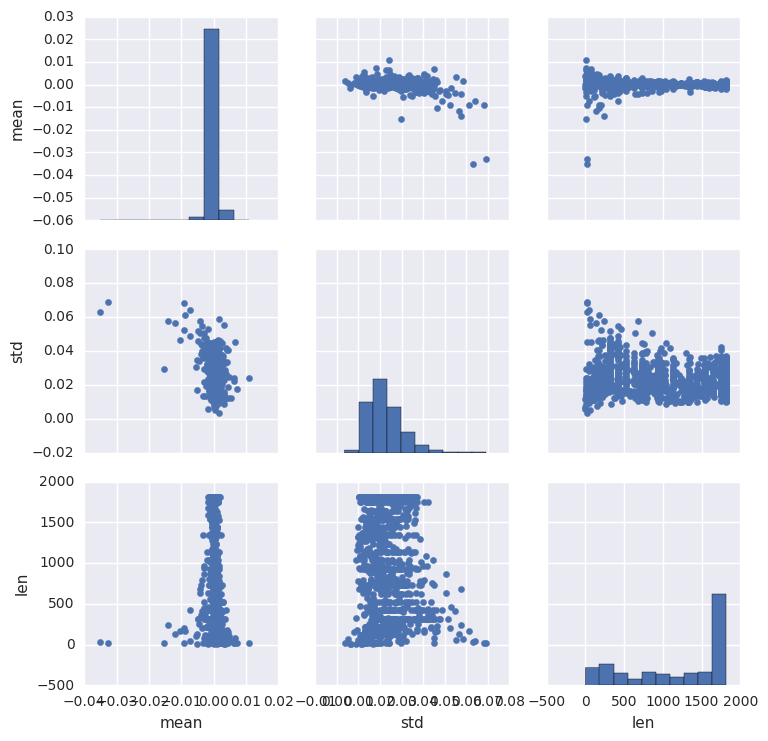

In [17]:
g = sns.PairGrid(assets_df, vars=["mean", "std", "len"])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

There seem to be some interesting relationships here. Notably, mean asset returns and holding period are negatively correlated with the std dev of returns.

Thanks for visiting! Next I'm going to look at time series of individual asset return and correlation with the portfolio returns...